In [1]:
%%writefile large_batch_training.py

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import random_split
from google.colab import files

def compute_mean_std(dataset):
    """Compute the mean and std of CIFAR-100 dataset.

    Args:
        dataset: A dataset derived from `torch.utils.data.Dataset`,
                 such as `cifar100_training_dataset` or `cifar100_test_dataset`.

    Returns:
        A tuple containing (mean, std) for the entire dataset.
    """

    # Extract images and labels
    data_r = np.stack([np.array(dataset[i][0])[:, :, 0] for i in range(len(dataset))])
    data_g = np.stack([np.array(dataset[i][0])[:, :, 1] for i in range(len(dataset))])
    data_b = np.stack([np.array(dataset[i][0])[:, :, 2] for i in range(len(dataset))])

    # Compute mean and std
    mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
    std = np.std(data_r), np.std(data_g), np.std(data_b)

    return mean, std

# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(384, 192)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model
net = LeNet5().to(device)

# Optimizer Subclasses
class LARS(optim.Optimizer):
    def __init__(self, params, lr, momentum=0.9, weight_decay=0, trust_coefficient=0.001):
        # Initialize the optimizer with the learning rate, momentum, weight decay, and trust coefficient
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, trust_coefficient=trust_coefficient)
        super(LARS, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it (commonly used for re-evaluating loss)
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                   # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                if len(state) == 0:
                    state['momentum_buffer'] = torch.clone(grad).detach()
                # Apply weight decay directly to the gradient
                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])
                # Compute the norms of the parameter and its gradient
                param_norm = torch.norm(p.data)
                grad_norm = torch.norm(grad)
                # Compute local learning rate based on the trust coefficient and norms
                if param_norm > 0 and grad_norm > 0:
                    local_lr = group['trust_coefficient'] * param_norm / (grad_norm + 1e-8)
                    grad = grad.mul(local_lr) # Scale the gradient with the local learning rate
                # Update the momentum buffer
                momentum_buffer = state['momentum_buffer']
                momentum_buffer.mul_(group['momentum']).add_(grad) #Momentum update
                state['momentum_buffer'] = momentum_buffer
                # Update the parameter
                p.data.add_(momentum_buffer, alpha=-group['lr']) # Gradient descent step with learning rate
        return loss

class LAMB(optim.Optimizer):
    def __init__(self, params, lr, weight_decay=0, betas=(0.9, 0.999), eps=1e-8):
        # Initialize the optimizer with learning rate, weight decay, betas for moment updates, and epsilon for stability
        defaults = dict(lr=lr, weight_decay=weight_decay, betas=betas, eps=eps)
        super(LAMB, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                # Initialize state
                if len(state) == 0:
                    # Initialize the state (step counter, first moment, second moment)
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data) # First moment (mean of gradients)
                    state['exp_avg_sq'] = torch.zeros_like(p.data) # Second moment (mean of squared gradients)
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']
                beta1, beta2 = group['betas']  # Coefficients for moment updates
                state['step'] += 1 # Increment step count
                step = state['step']
                # Decay the first and second moment running average coefficients
                # Update first and second moments
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1) # Exponential moving average of gradients
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2) # Exponential moving average of squared gradients
                # Correct bias in the first and second moments
                bias_correction1 = 1 - beta1 ** step
                bias_correction2 = 1 - beta2 ** step
                corrected_exp_avg = exp_avg / bias_correction1
                corrected_exp_avg_sq = exp_avg_sq / bias_correction2
                # Compute the denominator for scaling the update
                denom = corrected_exp_avg_sq.sqrt().add_(group['eps']) # Stability epsilon
                # Compute the step update
                update = corrected_exp_avg / denom
                # Apply weight decay directly to the parameters
                if group['weight_decay'] != 0:
                    update.add_(p.data, alpha=group['weight_decay'])
                # Compute the trust ratio (norm of parameters vs norm of update)
                param_norm = torch.norm(p.data)
                update_norm = torch.norm(update)
                trust_ratio = 1.0  # Default trust ratio
                if param_norm > 0 and update_norm > 0:
                    trust_ratio = param_norm / update_norm
                # Update the parameters
                p.data.add_(update, alpha=-group['lr'] * trust_ratio)
        return loss

class SqrtLRScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, base_lr, batch_size, warmup_epochs, total_epochs, reference_batch_size, verbose=False):
        """
        Args:
            optimizer: PyTorch optimizer (e.g., Adam, LAMB, LARS).
            base_lr: Base learning rate for the reference batch size.
            batch_size: Current batch size.
            warmup_epochs: Number of warmup epochs.
            total_epochs: Total number of epochs.
            reference_batch_size: Batch size for which the base_lr is defined.
            verbose: Whether to print LR updates.
        """
        self.base_lr = base_lr
        self.batch_size = batch_size
        self.scaled_lr = base_lr * (batch_size / reference_batch_size) ** 0.5
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.verbose = verbose
        super(SqrtLRScheduler, self).__init__(optimizer)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            # Linear warmup scaling
            warmup_factor = (epoch + 1) / self.warmup_epochs
            return [warmup_factor * self.scaled_lr for _ in self.optimizer.param_groups]
        else:
            # polynomially decaying learning rate of ηt = η0×(1−t/T)
            if epoch == self.warmup_epochs:
                print(f"Warmup phase completed at epoch {epoch}. Switching to constant learning rate.")
            return [self.scaled_lr * ( 1 - ( (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs))) for _ in self.optimizer.param_groups]

# Command-line arguments
parser = argparse.ArgumentParser(description='Train with Large-Batch Optimizers')
parser.add_argument('--optimizer', type=str, default='SGDM', choices=['SGDM', 'AdamW', 'LARS', 'LAMB'],
                    help='Choose optimizer')
parser.add_argument('--batch-size', type=int, default=128, help='Batch size')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGDM and LARS')
parser.add_argument('--weight-decay', type=float, default=1e-5, help='Weight decay')
parser.add_argument('--b1', type=float, default=0.9, help='Beta1 for AdamW')
parser.add_argument('--b2', type=float, default=0.999, help='Beta2 for AdamW')
parser.add_argument('--trust-coefficient', type=float, default=0.001, help='Trust coefficient for LARS')
parser.add_argument('--epochs', type=int, default=150, help='Number of epochs')
parser.add_argument('--warmup-epochs', type=int, default=5, help='Number of epochs')
args = parser.parse_args()


torch.manual_seed(42) # Set the seed for reproducibility
torch.cuda.manual_seed_all(42) # Set the seed for reproducibility on GPU

# use the same mean and std to add consistency to all datasets
data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(data)

# Load and split CIFAR-100 dataset
train_transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=2)


# Fixed parameter from paper [18] to calculate the square root LR scaling value
# base_lr = 5 / (2**3 * 10**3)
# reference_batch_size = 512
#scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5

# Mapping optimizers
if args.optimizer == 'SGDM':
    base_lr = 1e-2
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.SGD(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'AdamW':
    base_lr = 5e-4
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.AdamW(net.parameters(), lr=scaled_lr, betas=(args.b1, args.b2), weight_decay=args.weight_decay)
elif args.optimizer == 'LARS':
    base_lr = 5e-1
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LARS(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay, trust_coefficient=args.trust_coefficient)
elif args.optimizer == 'LAMB':
    base_lr = 5e-4
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LAMB(net.parameters(), lr=scaled_lr, weight_decay=args.weight_decay)

criterion = nn.CrossEntropyLoss()

# scheduler should be e square root LR scaling rule and linear-epoch warmup scheduling to automatically adjust learning rate
scheduler = SqrtLRScheduler(
    optimizer = optimizer,
    base_lr = base_lr,
    batch_size = args.batch_size,
    warmup_epochs = args.warmup_epochs,
    total_epochs = args.epochs,
    reference_batch_size = reference_batch_size,
    verbose = True)

# Training Function
def train_model(optimizer, scheduler, model, criterion, trainloader , testloader, device, epochs, save_checkpoint_interval=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        '''
        # Early Stopping
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1

        if epochs_no_improve == patience:
          print("Early stopping!")
          break
        '''

        # Test
        correct_test, total_test, test_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()
        test_loss /= len(testloader)
        test_losses.append(test_loss)
        test_accuracy = 100. * correct_test / total_test
        test_accuracies.append(test_accuracy)

        scheduler.step()

        # Checkpointing
        if (epoch + 1) % save_checkpoint_interval == 0:
            checkpoint_filename = f'checkpoint_epoch_{epoch + 1}.pth'
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss.item(),
            }
            checkpoint_path = os.path.join('./', checkpoint_filename)
            torch.save(checkpoint, checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch + 1}: {checkpoint_path}')

            # Download the checkpoint
            files.download(checkpoint_filename)

        print(f'Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

# Train the model
print(f"--- Train with {args.optimizer} ---")
train_loss, test_loss, train_acc, test_acc = train_model(optimizer, scheduler, net, criterion, trainloader, testloader, device, args.epochs)

# Save model
torch.save(net.state_dict(), f'net_{args.optimizer}.pth')

# Plot results
# Plot Training Loss
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('train_loss.png')
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(6, 4))
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('train_accuracy.png')
plt.show()

# Plot Test Loss
plt.figure(figsize=(6, 4))
plt.plot(test_loss, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('test_loss.png')
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(6, 4))
plt.plot(test_acc, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('test_accuracy.png')
plt.show()

Writing large_batch_training.py


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
--- Train with LAMB ---
Epoch 1/150, Train Acc: 0.91%, Test Acc: 1.08%
Epoch 1/150, Train Loss: 4.6044, Test Loss: 4.6014
Epoch 2/150, Train Acc: 1.27%, Test Acc: 2.29%
Epoch 2/150, Train Loss: 4.5953, Test Loss: 4.5843
Epoch 3/150, Train Acc: 2.54%, Test Acc: 3.05%
Epoch 3/150, Train Loss: 4.5609, Test Loss: 4.5241
Epoch 4/150, Train Acc: 3.32%, Test Acc: 4.64%
Epoch 4/150, Train Loss: 4.4729, Test Loss: 4.3829
Warmup phase completed at epoch 5. Switching to constant learning rate.
Epoch 5/150, Train Acc: 5.21%, Test Acc: 6.81%
Epoch 5/150, Train Loss: 4.3019, Test Loss: 4.1657
Epoch 6/150, Train Acc: 7.25%, Test Acc: 8.57%
Epoch 6/150, Train Loss: 4.1311, Test Loss: 4.0409
Epoch 7/150, Train Acc: 8.18%, Test Acc: 9.31%
Epoch 7/150, Train Loss: 4.0434, Test Loss: 3.9722
Epoch 8/150, Train Acc: 9.57%, Test Acc: 11.61%
Epoch 8/150, Train Loss: 3.9627, Test Loss: 3.8654
Epoch

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 10/150, Train Acc: 12.58%, Test Acc: 14.24%
Epoch 10/150, Train Loss: 3.7976, Test Loss: 3.7023
Epoch 11/150, Train Acc: 13.57%, Test Acc: 14.53%
Epoch 11/150, Train Loss: 3.7339, Test Loss: 3.6504
Epoch 12/150, Train Acc: 14.55%, Test Acc: 16.41%
Epoch 12/150, Train Loss: 3.6647, Test Loss: 3.5675
Epoch 13/150, Train Acc: 15.69%, Test Acc: 16.48%
Epoch 13/150, Train Loss: 3.5998, Test Loss: 3.5368
Epoch 14/150, Train Acc: 16.63%, Test Acc: 18.10%
Epoch 14/150, Train Loss: 3.5412, Test Loss: 3.4877
Epoch 15/150, Train Acc: 17.66%, Test Acc: 18.64%
Epoch 15/150, Train Loss: 3.4880, Test Loss: 3.4075
Epoch 16/150, Train Acc: 18.56%, Test Acc: 19.25%
Epoch 16/150, Train Loss: 3.4269, Test Loss: 3.3828
Epoch 17/150, Train Acc: 19.42%, Test Acc: 20.60%
Epoch 17/150, Train Loss: 3.3824, Test Loss: 3.3187
Epoch 18/150, Train Acc: 20.28%, Test Acc: 21.64%
Epoch 18/150, Train Loss: 3.3347, Test Loss: 3.2672
Epoch 19/150, Train Acc: 20.77%, Test Acc: 22.23%
Epoch 19/150, Train Loss: 3.3000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 20/150, Train Acc: 21.50%, Test Acc: 23.06%
Epoch 20/150, Train Loss: 3.2556, Test Loss: 3.1943
Epoch 21/150, Train Acc: 22.35%, Test Acc: 22.78%
Epoch 21/150, Train Loss: 3.2156, Test Loss: 3.1913
Epoch 22/150, Train Acc: 22.96%, Test Acc: 24.40%
Epoch 22/150, Train Loss: 3.1806, Test Loss: 3.1024
Epoch 23/150, Train Acc: 23.43%, Test Acc: 24.77%
Epoch 23/150, Train Loss: 3.1524, Test Loss: 3.0854
Epoch 24/150, Train Acc: 24.21%, Test Acc: 26.54%
Epoch 24/150, Train Loss: 3.1163, Test Loss: 3.0287
Epoch 25/150, Train Acc: 24.87%, Test Acc: 26.27%
Epoch 25/150, Train Loss: 3.0710, Test Loss: 3.0124
Epoch 26/150, Train Acc: 25.64%, Test Acc: 26.36%
Epoch 26/150, Train Loss: 3.0440, Test Loss: 2.9982
Epoch 27/150, Train Acc: 25.92%, Test Acc: 26.50%
Epoch 27/150, Train Loss: 3.0089, Test Loss: 2.9892
Epoch 28/150, Train Acc: 26.60%, Test Acc: 27.71%
Epoch 28/150, Train Loss: 2.9909, Test Loss: 2.9459
Epoch 29/150, Train Acc: 27.35%, Test Acc: 29.01%
Epoch 29/150, Train Loss: 2.9456

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 30/150, Train Acc: 27.80%, Test Acc: 28.53%
Epoch 30/150, Train Loss: 2.9336, Test Loss: 2.8882
Epoch 31/150, Train Acc: 27.99%, Test Acc: 30.41%
Epoch 31/150, Train Loss: 2.8995, Test Loss: 2.8187
Epoch 32/150, Train Acc: 28.74%, Test Acc: 30.62%
Epoch 32/150, Train Loss: 2.8770, Test Loss: 2.7903
Epoch 33/150, Train Acc: 29.23%, Test Acc: 30.51%
Epoch 33/150, Train Loss: 2.8545, Test Loss: 2.7952
Epoch 34/150, Train Acc: 29.45%, Test Acc: 31.56%
Epoch 34/150, Train Loss: 2.8368, Test Loss: 2.7513
Epoch 35/150, Train Acc: 30.18%, Test Acc: 31.53%
Epoch 35/150, Train Loss: 2.8181, Test Loss: 2.7381
Epoch 36/150, Train Acc: 30.26%, Test Acc: 31.70%
Epoch 36/150, Train Loss: 2.7991, Test Loss: 2.7274
Epoch 37/150, Train Acc: 30.73%, Test Acc: 32.70%
Epoch 37/150, Train Loss: 2.7693, Test Loss: 2.6852
Epoch 38/150, Train Acc: 30.96%, Test Acc: 31.23%
Epoch 38/150, Train Loss: 2.7701, Test Loss: 2.7430
Epoch 39/150, Train Acc: 31.19%, Test Acc: 32.41%
Epoch 39/150, Train Loss: 2.7414

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 40/150, Train Acc: 31.96%, Test Acc: 33.89%
Epoch 40/150, Train Loss: 2.7124, Test Loss: 2.6372
Epoch 41/150, Train Acc: 32.41%, Test Acc: 33.72%
Epoch 41/150, Train Loss: 2.6893, Test Loss: 2.6353
Epoch 42/150, Train Acc: 32.90%, Test Acc: 33.48%
Epoch 42/150, Train Loss: 2.6636, Test Loss: 2.6365
Epoch 43/150, Train Acc: 33.14%, Test Acc: 34.60%
Epoch 43/150, Train Loss: 2.6549, Test Loss: 2.5734
Epoch 44/150, Train Acc: 33.56%, Test Acc: 35.24%
Epoch 44/150, Train Loss: 2.6261, Test Loss: 2.5621
Epoch 45/150, Train Acc: 34.18%, Test Acc: 34.16%
Epoch 45/150, Train Loss: 2.6055, Test Loss: 2.5958
Epoch 46/150, Train Acc: 34.42%, Test Acc: 35.83%
Epoch 46/150, Train Loss: 2.5871, Test Loss: 2.5234
Epoch 47/150, Train Acc: 34.90%, Test Acc: 35.85%
Epoch 47/150, Train Loss: 2.5692, Test Loss: 2.5239
Epoch 48/150, Train Acc: 35.08%, Test Acc: 35.95%
Epoch 48/150, Train Loss: 2.5504, Test Loss: 2.5177
Epoch 49/150, Train Acc: 35.57%, Test Acc: 36.27%
Epoch 49/150, Train Loss: 2.5324

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 50/150, Train Acc: 36.09%, Test Acc: 36.84%
Epoch 50/150, Train Loss: 2.5165, Test Loss: 2.4666
Epoch 51/150, Train Acc: 36.44%, Test Acc: 37.07%
Epoch 51/150, Train Loss: 2.4912, Test Loss: 2.4601
Epoch 52/150, Train Acc: 36.31%, Test Acc: 36.71%
Epoch 52/150, Train Loss: 2.4956, Test Loss: 2.4661
Epoch 53/150, Train Acc: 36.83%, Test Acc: 37.50%
Epoch 53/150, Train Loss: 2.4802, Test Loss: 2.4449
Epoch 54/150, Train Acc: 37.26%, Test Acc: 37.50%
Epoch 54/150, Train Loss: 2.4476, Test Loss: 2.4360
Epoch 55/150, Train Acc: 37.11%, Test Acc: 37.96%
Epoch 55/150, Train Loss: 2.4546, Test Loss: 2.4118
Epoch 56/150, Train Acc: 37.62%, Test Acc: 38.49%
Epoch 56/150, Train Loss: 2.4538, Test Loss: 2.4104
Epoch 57/150, Train Acc: 37.93%, Test Acc: 37.93%
Epoch 57/150, Train Loss: 2.4197, Test Loss: 2.4114
Epoch 58/150, Train Acc: 38.00%, Test Acc: 38.24%
Epoch 58/150, Train Loss: 2.4007, Test Loss: 2.4069
Epoch 59/150, Train Acc: 38.46%, Test Acc: 38.96%
Epoch 59/150, Train Loss: 2.3880

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 60/150, Train Acc: 38.66%, Test Acc: 39.05%
Epoch 60/150, Train Loss: 2.3884, Test Loss: 2.3610
Epoch 61/150, Train Acc: 38.86%, Test Acc: 38.93%
Epoch 61/150, Train Loss: 2.3699, Test Loss: 2.3539
Epoch 62/150, Train Acc: 39.42%, Test Acc: 39.36%
Epoch 62/150, Train Loss: 2.3471, Test Loss: 2.3465
Epoch 63/150, Train Acc: 39.65%, Test Acc: 40.12%
Epoch 63/150, Train Loss: 2.3303, Test Loss: 2.3245
Epoch 64/150, Train Acc: 40.15%, Test Acc: 39.38%
Epoch 64/150, Train Loss: 2.3183, Test Loss: 2.3378
Epoch 65/150, Train Acc: 40.04%, Test Acc: 40.22%
Epoch 65/150, Train Loss: 2.3145, Test Loss: 2.3188
Epoch 66/150, Train Acc: 40.26%, Test Acc: 40.08%
Epoch 66/150, Train Loss: 2.3032, Test Loss: 2.3166
Epoch 67/150, Train Acc: 40.69%, Test Acc: 40.28%
Epoch 67/150, Train Loss: 2.2918, Test Loss: 2.3073
Epoch 68/150, Train Acc: 40.78%, Test Acc: 41.30%
Epoch 68/150, Train Loss: 2.2844, Test Loss: 2.2784
Epoch 69/150, Train Acc: 41.26%, Test Acc: 40.95%
Epoch 69/150, Train Loss: 2.2714

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 70/150, Train Acc: 41.38%, Test Acc: 41.00%
Epoch 70/150, Train Loss: 2.2556, Test Loss: 2.2829
Epoch 71/150, Train Acc: 41.47%, Test Acc: 41.40%
Epoch 71/150, Train Loss: 2.2566, Test Loss: 2.2695
Epoch 72/150, Train Acc: 41.64%, Test Acc: 41.00%
Epoch 72/150, Train Loss: 2.2507, Test Loss: 2.2675
Epoch 73/150, Train Acc: 42.01%, Test Acc: 41.61%
Epoch 73/150, Train Loss: 2.2302, Test Loss: 2.2666
Epoch 74/150, Train Acc: 42.21%, Test Acc: 41.95%
Epoch 74/150, Train Loss: 2.2179, Test Loss: 2.2418
Epoch 75/150, Train Acc: 42.51%, Test Acc: 41.50%
Epoch 75/150, Train Loss: 2.2133, Test Loss: 2.2600
Epoch 76/150, Train Acc: 42.53%, Test Acc: 41.84%
Epoch 76/150, Train Loss: 2.2213, Test Loss: 2.2389
Epoch 77/150, Train Acc: 42.88%, Test Acc: 42.04%
Epoch 77/150, Train Loss: 2.1959, Test Loss: 2.2314
Epoch 78/150, Train Acc: 43.24%, Test Acc: 42.30%
Epoch 78/150, Train Loss: 2.1858, Test Loss: 2.2285
Epoch 79/150, Train Acc: 43.30%, Test Acc: 42.96%
Epoch 79/150, Train Loss: 2.1824

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 80/150, Train Acc: 43.67%, Test Acc: 42.37%
Epoch 80/150, Train Loss: 2.1666, Test Loss: 2.2236
Epoch 81/150, Train Acc: 43.21%, Test Acc: 42.25%
Epoch 81/150, Train Loss: 2.1727, Test Loss: 2.2177
Epoch 82/150, Train Acc: 43.49%, Test Acc: 42.54%
Epoch 82/150, Train Loss: 2.1706, Test Loss: 2.2188
Epoch 83/150, Train Acc: 43.83%, Test Acc: 42.34%
Epoch 83/150, Train Loss: 2.1480, Test Loss: 2.2182
Epoch 84/150, Train Acc: 43.94%, Test Acc: 42.73%
Epoch 84/150, Train Loss: 2.1457, Test Loss: 2.2033
Epoch 85/150, Train Acc: 44.15%, Test Acc: 43.18%
Epoch 85/150, Train Loss: 2.1303, Test Loss: 2.1877
Epoch 86/150, Train Acc: 44.02%, Test Acc: 42.25%
Epoch 86/150, Train Loss: 2.1284, Test Loss: 2.2078
Epoch 87/150, Train Acc: 44.29%, Test Acc: 43.29%
Epoch 87/150, Train Loss: 2.1175, Test Loss: 2.1895
Epoch 88/150, Train Acc: 44.55%, Test Acc: 42.48%
Epoch 88/150, Train Loss: 2.1093, Test Loss: 2.2305
Epoch 89/150, Train Acc: 44.73%, Test Acc: 43.14%
Epoch 89/150, Train Loss: 2.1140

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 90/150, Train Acc: 44.71%, Test Acc: 42.76%
Epoch 90/150, Train Loss: 2.1094, Test Loss: 2.1982
Epoch 91/150, Train Acc: 44.65%, Test Acc: 43.45%
Epoch 91/150, Train Loss: 2.1063, Test Loss: 2.1733
Epoch 92/150, Train Acc: 45.15%, Test Acc: 43.13%
Epoch 92/150, Train Loss: 2.0867, Test Loss: 2.1849
Epoch 93/150, Train Acc: 45.17%, Test Acc: 43.31%
Epoch 93/150, Train Loss: 2.0841, Test Loss: 2.1734
Epoch 94/150, Train Acc: 45.51%, Test Acc: 43.55%
Epoch 94/150, Train Loss: 2.0752, Test Loss: 2.1596
Epoch 95/150, Train Acc: 45.59%, Test Acc: 43.92%
Epoch 95/150, Train Loss: 2.0679, Test Loss: 2.1549
Epoch 96/150, Train Acc: 45.84%, Test Acc: 43.46%
Epoch 96/150, Train Loss: 2.0567, Test Loss: 2.1547
Epoch 97/150, Train Acc: 45.70%, Test Acc: 43.61%
Epoch 97/150, Train Loss: 2.0561, Test Loss: 2.1580
Epoch 98/150, Train Acc: 46.23%, Test Acc: 43.93%
Epoch 98/150, Train Loss: 2.0494, Test Loss: 2.1481
Epoch 99/150, Train Acc: 46.14%, Test Acc: 43.71%
Epoch 99/150, Train Loss: 2.0472

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 100/150, Train Acc: 46.23%, Test Acc: 44.23%
Epoch 100/150, Train Loss: 2.0401, Test Loss: 2.1397
Epoch 101/150, Train Acc: 46.50%, Test Acc: 44.17%
Epoch 101/150, Train Loss: 2.0334, Test Loss: 2.1423
Epoch 102/150, Train Acc: 46.39%, Test Acc: 44.46%
Epoch 102/150, Train Loss: 2.0268, Test Loss: 2.1267
Epoch 103/150, Train Acc: 46.84%, Test Acc: 44.04%
Epoch 103/150, Train Loss: 2.0150, Test Loss: 2.1375
Epoch 104/150, Train Acc: 46.90%, Test Acc: 44.19%
Epoch 104/150, Train Loss: 2.0181, Test Loss: 2.1312
Epoch 105/150, Train Acc: 46.68%, Test Acc: 44.52%
Epoch 105/150, Train Loss: 2.0214, Test Loss: 2.1253
Epoch 106/150, Train Acc: 47.08%, Test Acc: 44.30%
Epoch 106/150, Train Loss: 2.0099, Test Loss: 2.1317
Epoch 107/150, Train Acc: 47.27%, Test Acc: 44.23%
Epoch 107/150, Train Loss: 2.0010, Test Loss: 2.1306
Epoch 108/150, Train Acc: 47.05%, Test Acc: 44.48%
Epoch 108/150, Train Loss: 1.9993, Test Loss: 2.1200
Epoch 109/150, Train Acc: 47.37%, Test Acc: 44.61%
Epoch 109/150

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 110/150, Train Acc: 47.64%, Test Acc: 44.45%
Epoch 110/150, Train Loss: 1.9777, Test Loss: 2.1181
Epoch 111/150, Train Acc: 47.72%, Test Acc: 44.56%
Epoch 111/150, Train Loss: 1.9756, Test Loss: 2.1102
Epoch 112/150, Train Acc: 47.82%, Test Acc: 44.37%
Epoch 112/150, Train Loss: 1.9696, Test Loss: 2.1201
Epoch 113/150, Train Acc: 47.78%, Test Acc: 45.29%
Epoch 113/150, Train Loss: 1.9696, Test Loss: 2.1088
Epoch 114/150, Train Acc: 47.73%, Test Acc: 45.09%
Epoch 114/150, Train Loss: 1.9706, Test Loss: 2.1126
Epoch 115/150, Train Acc: 47.96%, Test Acc: 44.89%
Epoch 115/150, Train Loss: 1.9549, Test Loss: 2.1001
Epoch 116/150, Train Acc: 48.12%, Test Acc: 45.01%
Epoch 116/150, Train Loss: 1.9602, Test Loss: 2.1092
Epoch 117/150, Train Acc: 48.08%, Test Acc: 45.21%
Epoch 117/150, Train Loss: 1.9596, Test Loss: 2.1031
Epoch 118/150, Train Acc: 48.28%, Test Acc: 45.32%
Epoch 118/150, Train Loss: 1.9549, Test Loss: 2.1011
Epoch 119/150, Train Acc: 48.28%, Test Acc: 45.16%
Epoch 119/150

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 120/150, Train Acc: 48.54%, Test Acc: 45.03%
Epoch 120/150, Train Loss: 1.9351, Test Loss: 2.0995
Epoch 121/150, Train Acc: 48.22%, Test Acc: 45.02%
Epoch 121/150, Train Loss: 1.9431, Test Loss: 2.0962
Epoch 122/150, Train Acc: 48.53%, Test Acc: 45.09%
Epoch 122/150, Train Loss: 1.9369, Test Loss: 2.0940
Epoch 123/150, Train Acc: 48.65%, Test Acc: 45.11%
Epoch 123/150, Train Loss: 1.9315, Test Loss: 2.0897
Epoch 124/150, Train Acc: 48.79%, Test Acc: 45.40%
Epoch 124/150, Train Loss: 1.9259, Test Loss: 2.0919
Epoch 125/150, Train Acc: 48.89%, Test Acc: 45.21%
Epoch 125/150, Train Loss: 1.9248, Test Loss: 2.0926
Epoch 126/150, Train Acc: 48.94%, Test Acc: 45.51%
Epoch 126/150, Train Loss: 1.9176, Test Loss: 2.0851
Epoch 127/150, Train Acc: 49.31%, Test Acc: 45.29%
Epoch 127/150, Train Loss: 1.9107, Test Loss: 2.0879
Epoch 128/150, Train Acc: 49.25%, Test Acc: 45.50%
Epoch 128/150, Train Loss: 1.9196, Test Loss: 2.0939
Epoch 129/150, Train Acc: 49.26%, Test Acc: 45.18%
Epoch 129/150

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 130/150, Train Acc: 49.30%, Test Acc: 45.31%
Epoch 130/150, Train Loss: 1.9102, Test Loss: 2.0900
Epoch 131/150, Train Acc: 49.57%, Test Acc: 45.38%
Epoch 131/150, Train Loss: 1.9017, Test Loss: 2.0828
Epoch 132/150, Train Acc: 49.46%, Test Acc: 45.65%
Epoch 132/150, Train Loss: 1.9026, Test Loss: 2.0817
Epoch 133/150, Train Acc: 49.72%, Test Acc: 45.79%
Epoch 133/150, Train Loss: 1.8930, Test Loss: 2.0827
Epoch 134/150, Train Acc: 49.38%, Test Acc: 45.65%
Epoch 134/150, Train Loss: 1.9082, Test Loss: 2.0812
Epoch 135/150, Train Acc: 49.48%, Test Acc: 45.84%
Epoch 135/150, Train Loss: 1.8941, Test Loss: 2.0771
Epoch 136/150, Train Acc: 49.43%, Test Acc: 45.82%
Epoch 136/150, Train Loss: 1.8846, Test Loss: 2.0732
Epoch 137/150, Train Acc: 49.82%, Test Acc: 45.64%
Epoch 137/150, Train Loss: 1.8963, Test Loss: 2.0739
Epoch 138/150, Train Acc: 49.58%, Test Acc: 45.54%
Epoch 138/150, Train Loss: 1.8863, Test Loss: 2.0703
Epoch 139/150, Train Acc: 49.88%, Test Acc: 45.73%
Epoch 139/150

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 140/150, Train Acc: 49.89%, Test Acc: 45.74%
Epoch 140/150, Train Loss: 1.8870, Test Loss: 2.0698
Epoch 141/150, Train Acc: 49.96%, Test Acc: 45.72%
Epoch 141/150, Train Loss: 1.8811, Test Loss: 2.0702
Epoch 142/150, Train Acc: 50.03%, Test Acc: 45.78%
Epoch 142/150, Train Loss: 1.8894, Test Loss: 2.0688
Epoch 143/150, Train Acc: 50.18%, Test Acc: 45.82%
Epoch 143/150, Train Loss: 1.8718, Test Loss: 2.0669
Epoch 144/150, Train Acc: 50.17%, Test Acc: 45.77%
Epoch 144/150, Train Loss: 1.8772, Test Loss: 2.0707
Epoch 145/150, Train Acc: 50.07%, Test Acc: 46.03%
Epoch 145/150, Train Loss: 1.8815, Test Loss: 2.0694
Epoch 146/150, Train Acc: 50.08%, Test Acc: 45.89%
Epoch 146/150, Train Loss: 1.8680, Test Loss: 2.0696
Epoch 147/150, Train Acc: 50.41%, Test Acc: 45.95%
Epoch 147/150, Train Loss: 1.8645, Test Loss: 2.0687
Epoch 148/150, Train Acc: 50.15%, Test Acc: 45.89%
Epoch 148/150, Train Loss: 1.8703, Test Loss: 2.0669
Epoch 149/150, Train Acc: 50.39%, Test Acc: 46.02%
Epoch 149/150

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 150/150, Train Acc: 50.03%, Test Acc: 46.03%
Epoch 150/150, Train Loss: 1.8735, Test Loss: 2.0653


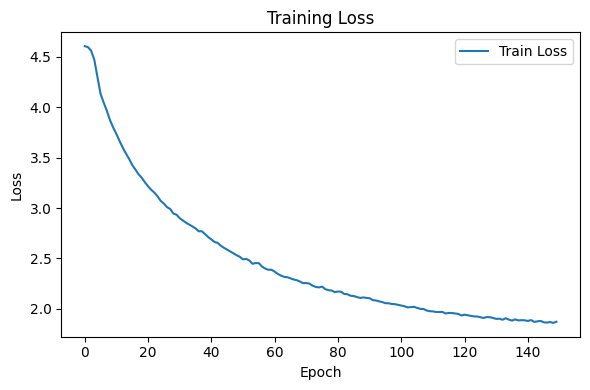

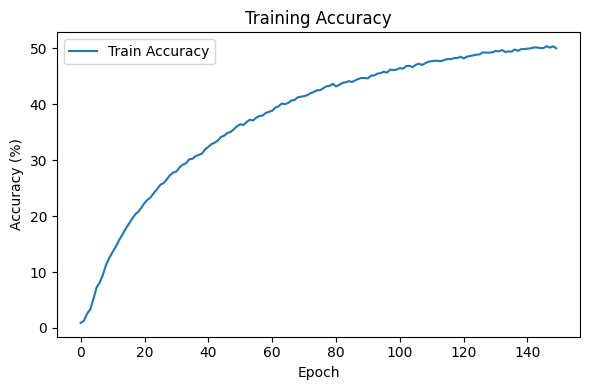

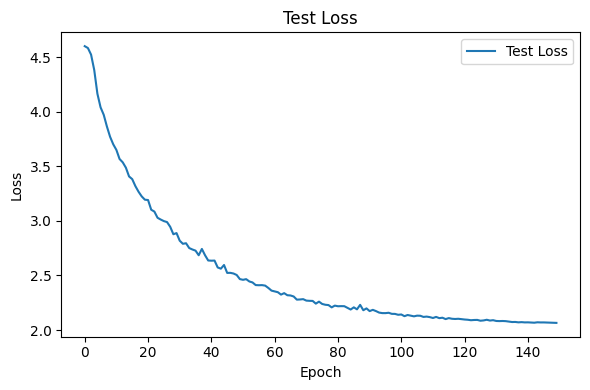

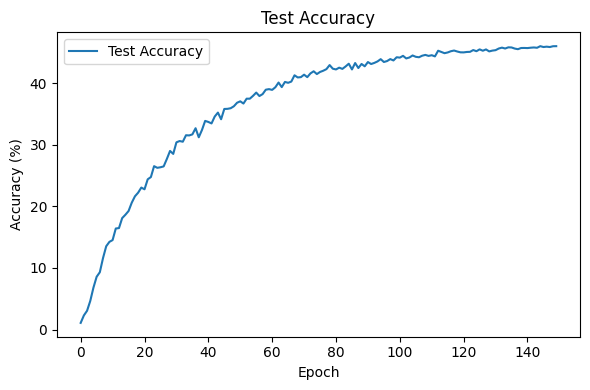

<Figure size 640x480 with 0 Axes>

In [3]:
%run large_batch_training.py --optimizer LAMB --batch-size 4096 --weight-decay 1e-1